In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

In [2]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
            
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [3]:
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb

In [4]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = .1
max_epoch = 100

In [5]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

In [6]:
xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

corpus size: 1000, vocabulary size: 418


In [7]:
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

In [8]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

In [9]:
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

In [10]:
for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f' % (epoch + 1, ppl))
    
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

| epoch 1 | perplexity 368.78
| epoch 2 | perplexity 246.65
| epoch 3 | perplexity 221.68
| epoch 4 | perplexity 213.35
| epoch 5 | perplexity 204.25
| epoch 6 | perplexity 201.80
| epoch 7 | perplexity 197.60
| epoch 8 | perplexity 196.69
| epoch 9 | perplexity 191.62
| epoch 10 | perplexity 191.78
| epoch 11 | perplexity 188.76
| epoch 12 | perplexity 192.23
| epoch 13 | perplexity 189.02
| epoch 14 | perplexity 190.57
| epoch 15 | perplexity 189.36
| epoch 16 | perplexity 185.95
| epoch 17 | perplexity 184.10
| epoch 18 | perplexity 181.16
| epoch 19 | perplexity 181.42
| epoch 20 | perplexity 182.51
| epoch 21 | perplexity 180.72
| epoch 22 | perplexity 176.07
| epoch 23 | perplexity 173.55
| epoch 24 | perplexity 173.90
| epoch 25 | perplexity 171.83
| epoch 26 | perplexity 173.28
| epoch 27 | perplexity 167.98
| epoch 28 | perplexity 163.89
| epoch 29 | perplexity 160.29
| epoch 30 | perplexity 158.58
| epoch 31 | perplexity 156.33
| epoch 32 | perplexity 151.24
| epoch 33 | perp

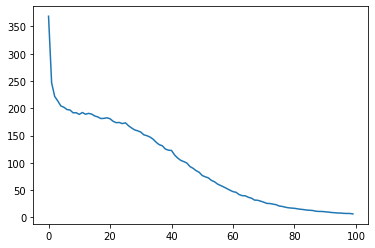

In [12]:
plt.plot(range(max_epoch), ppl_list)
plt.show()